In [1]:
import sys
sys.path.append('../src')

In [14]:
import numpy as np

from liab.scm import ComponentOrEquation, GSym, System
from liab.failure import ClosedHalfSpace
from liab.k_leg_liab import k_leg_liab
from liab.shapley_liab import shapley_liab

NUM_m = 10
K = 2

a_sp = ComponentOrEquation(['a'], 'A', 'a')
b_sp = ComponentOrEquation(['b'], 'B', 'b')
c_sp = ComponentOrEquation(['c'], 'C', 'c')
d_sp = ComponentOrEquation(['d', 'A', 'B', 'C'], 'D', 'd+Max(A*B,A*C,B*C)')
a_ims = [ComponentOrEquation(['a'], 'A', f'a+{m*10}') for m in range(NUM_m)]
b_im = ComponentOrEquation(['b'], 'B', 'b+10')
c_im = ComponentOrEquation(['c'], 'C', 'c+8')
d_im = ComponentOrEquation(['d', 'A', 'B', 'C'], 'D', 'd+Max(A*B,A*C,B*C)+10')

In [15]:
S = System([a_sp, b_sp, c_sp, d_sp])
Ts = [System([a_ims[i], b_im, c_im, d_im]) for i in range(NUM_m)]

print(f'{S=}')
print(f'{Ts[0]=}')

S=System(cs=[ComponentOrEquation(I=['a'], O=A, f=a), ComponentOrEquation(I=['b'], O=B, f=b), ComponentOrEquation(I=['c'], O=C, f=c), ComponentOrEquation(I=['d', 'A', 'B', 'C'], O=D, f=d+Max(A*B,A*C,B*C))])
Ts[0]=System(cs=[ComponentOrEquation(I=['a'], O=A, f=a+0), ComponentOrEquation(I=['b'], O=B, f=b+10), ComponentOrEquation(I=['c'], O=C, f=c+8), ComponentOrEquation(I=['d', 'A', 'B', 'C'], O=D, f=d+Max(A*B,A*C,B*C)+10)])


In [16]:
M = S.induced_scm()
Ns = [T.induced_scm(state_order=M.state_order) for T in Ts]
print(f'{M=}')
print(f'{Ns[0]=}')

M=SCM(U={'b', 'a', 'c', 'd'}, V={'D', 'A', 'B', 'C'}, cs={'A': ComponentOrEquation(I=['a'], O=A, f=a), 'B': ComponentOrEquation(I=['b'], O=B, f=b), 'C': ComponentOrEquation(I=['c'], O=C, f=c), 'D': ComponentOrEquation(I=['d', 'A', 'B', 'C'], O=D, f=d+Max(A*B,A*C,B*C))}, state_order=['B', 'A', 'C', 'D'])
Ns[0]=SCM(U={'b', 'a', 'c', 'd'}, V={'D', 'A', 'B', 'C'}, cs={'A': ComponentOrEquation(I=['a'], O=A, f=a+0), 'B': ComponentOrEquation(I=['b'], O=B, f=b+10), 'C': ComponentOrEquation(I=['c'], O=C, f=c+8), 'D': ComponentOrEquation(I=['d', 'A', 'B', 'C'], O=D, f=d+Max(A*B,A*C,B*C)+10)}, state_order=['B', 'A', 'C', 'D'])


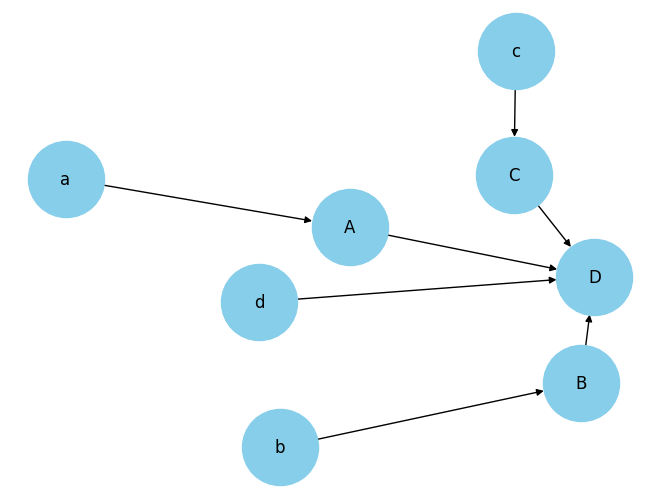

In [17]:
M.draw()

In [18]:
u = {'a': 10, 'b': 10, 'c': 10, 'd': 10}
F = ClosedHalfSpace({'D': (250, 'ge')})

In [19]:
print('Specification state at u=', M.get_state(u)[0])
print('Implementation state at u=', Ns[0].get_state(u)[0])

Specification state at u= {'B': 10.0, 'A': 10.0, 'C': 10.0, 'D': 110.0}
Implementation state at u= {'B': 20.0, 'A': 10.0, 'C': 18.0, 'D': 380.0}


In [20]:
for X in S.cs:
    print(f'Implementation/fixed-{X.O} state at u=', 
          Ts[0].get_replacement({X.O: X}).induced_scm().get_state(u)[0])

Implementation/fixed-A state at u= {'B': 20.0, 'A': 10.0, 'C': 18.0, 'D': 380.0}
Implementation/fixed-B state at u= {'B': 10.0, 'A': 10.0, 'C': 18.0, 'D': 200.0}
Implementation/fixed-C state at u= {'B': 20.0, 'A': 10.0, 'C': 10.0, 'D': 220.0}
Implementation/fixed-D state at u= {'B': 20.0, 'A': 10.0, 'C': 18.0, 'D': 370.0}


In [21]:
assert S.induced_scm().get_state(u)[0] == {'A': 10, 'B': 10, 'C': 10, 'D': 110}
assert Ts[1].induced_scm().get_state(u)[0] == {'A': 20, 'B': 20, 'C': 18, 'D': 420}

In [30]:
k_leg_liabs = [k_leg_liab(Ts[m], S, u, F, k=K) for m in range(NUM_m)]
print(f'{k_leg_liabs[0]=}')

k_leg_liabs[0]={'A': 0.0, 'B': 0.5, 'C': 0.5, 'D': 0.0}


In [32]:
shapley_liabs = [shapley_liab(Ts[m], S, u, F, k=2) for m in range(NUM_m)]
print(f'{k_leg_liabs[0]=}')

k_leg_liabs[0]={'A': 0.0, 'B': 0.5, 'C': 0.5, 'D': 0.0}


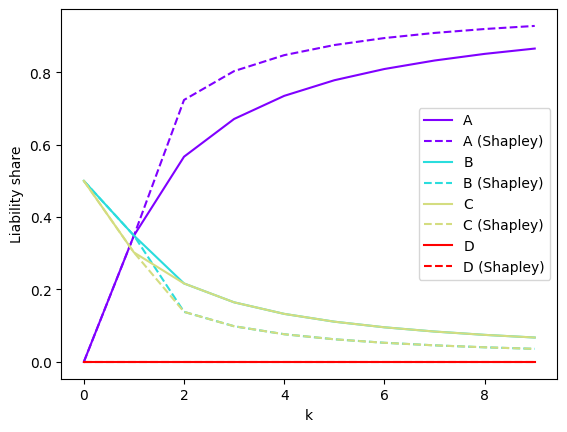

In [33]:
import matplotlib.pyplot as plt

# Extract the keys from the first element in liabs
keys = k_leg_liabs[0].keys()

# Create a color map for each key
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))

# Plot each key with a different color
for i, key in enumerate(keys):
    plt.plot(range(len(k_leg_liabs)), [liab[key] for liab in k_leg_liabs], color=colors[i], label=key)
    plt.plot(range(len(shapley_liabs)), [liab[key] for liab in shapley_liabs], color=colors[i], linestyle='dashed', label=f'{key} (Shapley)')

# Add legend and labels
plt.legend()
plt.xlabel('k')
plt.ylabel('Liability share')

# Show the plot
plt.show()